# The Battle of Neighborhoods | Finding a Better Place in North York, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

Importing Libraries

In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2.  Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [3]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [4]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [5]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [6]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M6C,North York,Downsview
freq,1,24,4


In [7]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [8]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [10]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M6C,North York,Downsview
freq,1,24,4


In [11]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M3H')

[43.75788000000006, -79.44846999999999]

In [13]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [14]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [15]:
df_2[df_2.Postalcode == 'M3H']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.75788,-79.44847


In [16]:
df_2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [17]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of North York, Toronto are : {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York, Toronto are : 43.7543263, -79.44911696639593.


### 3. Map of Toronoto

In [18]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [19]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood #1 are : {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood #1 are : 43.7543263, -79.44911696639593.


In [29]:
# @hiddel_cell
CLIENT_ID = '404YAURNUJCROHUQIR5VRFFZRVFXNJG4VXPF0FFNLKJ0KZCN' # my Foursquare ID
CLIENT_SECRET = '3BWEDVPCAYZGQFZ2KSOVVOCFIBCNKGUSYJQ01L1Y55FF0FD3' # my Foursquare Secret
VERSION = '20180605'
#LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 404YAURNUJCROHUQIR5VRFFZRVFXNJG4VXPF0FFNLKJ0KZCN
CLIENT_SECRET: 3BWEDVPCAYZGQFZ2KSOVVOCFIBCNKGUSYJQ01L1Y55FF0FD3


In [30]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [31]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [32]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [33]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
2,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
3,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


### 5. Categories of Nearby Venues/Locations

In [34]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
2,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
3,Tim Hortons,Coffee Shop,43.754767,-79.443250
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [35]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  2
Grocery Store                1
Restaurant                   1
Middle Eastern Restaurant    1
American Restaurant          1
Fried Chicken Joint          1
Coffee Shop                  1
Sushi Restaurant             1
Deli / Bodega                1
Mediterranean Restaurant     1
Name: categories, dtype: int64

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
# Nearby Venues
NorthYork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [38]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 307 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,24,24,24,24,24,24
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",14,14,14,14,14,14
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27


### One Hot Encoding of Features

In [39]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Zoo Exhibit,ATM,Accessories Store,Adult Boutique,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restauran

In [40]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0  Chinese Restaurant  0.08
1       Shopping Mall  0.08
2     Badminton Court  0.04
3                Bank  0.04
4    Sushi Restaurant  0.04


---- Alderwood, Long Branch ----
            venue  freq
0        Pharmacy  0.14
1             Pub  0.14
2     Gas Station  0.14
3     Pizza Place  0.14
4  Sandwich Place  0.14


---- Bathurst Manor, Wilson Heights, Downsview North ----
                       venue  freq
0                       Park  0.14
1                Coffee Shop  0.14
2  Middle Eastern Restaurant  0.07
3                 Restaurant  0.07
4             Sandwich Place  0.07


---- Bayview Village ----
              venue  freq
0             Trail  0.33
1       Flower Shop  0.17
2              Park  0.17
3  Asian Restaurant  0.17
4       Gas Station  0.17


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.07
1      Sandwich Place  0.07
2  Italian Restaurant  0.07
3          Restaurant

4             Mexican Restaurant  0.03


---- Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens ----
                 venue  freq
0          Dry Cleaner  0.14
1             Pharmacy  0.14
2       Sandwich Place  0.14
3  American Restaurant  0.14
4             Bus Line  0.14


---- Lawrence Manor, Lawrence Heights ----
            venue  freq
0  Clothing Store  0.17
1   Women's Store  0.05
2    Dessert Shop  0.05
3  Cosmetics Shop  0.05
4      Restaurant  0.05


---- Lawrence Park ----
                  venue  freq
0                  Park  0.14
1             Bookstore  0.14
2                  Café  0.14
3            Restaurant  0.14
4  Gym / Fitness Center  0.14


---- Leaside ----
                    venue  freq
0             Coffee Shop  0.08
1     Sporting Goods Shop  0.06
2            Burger Joint  0.04
3  Furniture / Home Store  0.04
4                    Bank  0.04


---- Little Portugal, Trinity ----
                venue  freq
0                 Bar  0.08
1  

4        Burger Joint  0.17


---- Willowdale, Newtonbrook ----
                       venue  freq
0          Korean Restaurant  0.19
1  Middle Eastern Restaurant  0.11
2                Coffee Shop  0.11
3                       Café  0.08
4                Pizza Place  0.05


---- Willowdale, Willowdale East ----
                  venue  freq
0           Coffee Shop  0.07
1           Pizza Place  0.06
2        Sandwich Place  0.05
3  Fast Food Restaurant  0.05
4   Japanese Restaurant  0.05


---- Willowdale, Willowdale West ----
            venue  freq
0      Baby Store  0.14
1     Pizza Place  0.14
2            Park  0.14
3   Grocery Store  0.14
4  Discount Store  0.14


---- Woburn ----
                  venue  freq
0           Coffee Shop  0.25
1                  Park  0.25
2    Chinese Restaurant  0.25
3  Fast Food Restaurant  0.25
4           Music Venue  0.00


---- Woodbine Heights ----
            venue  freq
0   Grocery Store  0.11
1            Café  0.07
2        Bus Line  0.0

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [42]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Pharmacy,Coffee Shop,Breakfast Spot,Café,Latin American Restaurant,Sandwich Place,Supermarket,Sushi Restaurant
1,"Alderwood, Long Branch",Sandwich Place,Pub,Coffee Shop,Pharmacy,Gym,Gas Station,Pizza Place,Eastern European Restaurant,Dive Bar,Dog Run
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Coffee Shop,Grocery Store,Fried Chicken Joint,Sandwich Place,Mediterranean Restaurant,Sushi Restaurant,Deli / Bodega,Restaurant,Pizza Place
3,Bayview Village,Trail,Flower Shop,Gas Station,Asian Restaurant,Park,Elementary School,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Boutique,Butcher,Juice Bar,Sushi Restaurant,Sports Club,Liquor Store,Pharmacy


### K-Means Clustering Approach

In [43]:
# Using K-Means to cluster neighborhood into 2 clusters
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0])

In [44]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthYork_merged =df_2.iloc[17:35,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#NorthYork_merged.head(18)# check the last columns!
NorthYork_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.80225,-79.35558,0,Park,Bakery,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Yoga Studio,Elementary School,Dry Cleaner,Dumpling Restaurant
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,1,Clothing Store,Coffee Shop,Bakery,Fast Food Restaurant,Sandwich Place,Bank,Juice Bar,Restaurant,Japanese Restaurant,Movie Theater
19,M2K,North York,Bayview Village,43.78112,-79.38060,0,Trail,Flower Shop,Gas Station,Asian Restaurant,Park,Elementary School,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
20,M2L,North York,"York Mills, Silver Hills",43.75698,-79.38060,0,Concert Hall,Park,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant
21,M2M,North York,"Willowdale, Newtonbrook",43.79182,-79.41372,1,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Pizza Place,Supermarket,Thai Restaurant,Diner,Sandwich Place,Dessert Shop
22,M2N,North York,"Willowdale, Willowdale East",43.76774,-79.40728,1,Coffee Shop,Pizza Place,Sandwich Place,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Bank,Grocery Store
23,M2P,North York,York Mills West,43.74778,-79.40033,1,Restaurant,Gym,Coffee Shop,Thai Restaurant,Park,Bus Station,Business Service,French Restaurant,Sandwich Place,Japanese Restaurant
24,M2R,North York,"Willowdale, Willowdale West",43.77989,-79.44678,1,Baby Store,Pizza Place,Discount Store,Pharmacy,Coffee Shop,Park,Grocery Store,Yoga Studio,Elementary School,Dry Cleaner
25,M3A,North York,Parkwoods,43.75245,-79.32991,0,Park,Pet Store,Food & Drink Shop,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
26,M3B,North York,Don Mills,43.74923,-79.36186,1,Coffee Shop,Restaurant,Japanese Restaurant,Science Museum,Bank,Gym,Sandwich Place,Beer Store,Supermarket,Dim Sum Restaurant


### Map of Clusters

In [45]:
kclusters = 10

In [68]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthYork_merged['Latitude'], 
                                   NorthYork_merged['Longitude'], 
                                   NorthYork_merged['Neighborhood'], 
                                   NorthYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1

In [47]:
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Hillcrest Village,0,Park,Bakery,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Yoga Studio,Elementary School,Dry Cleaner,Dumpling Restaurant
19,Bayview Village,0,Trail,Flower Shop,Gas Station,Asian Restaurant,Park,Elementary School,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
20,"York Mills, Silver Hills",0,Concert Hall,Park,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant
25,Parkwoods,0,Park,Pet Store,Food & Drink Shop,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant


Cluster 2

In [48]:
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",1,Clothing Store,Coffee Shop,Bakery,Fast Food Restaurant,Sandwich Place,Bank,Juice Bar,Restaurant,Japanese Restaurant,Movie Theater
21,"Willowdale, Newtonbrook",1,Korean Restaurant,Coffee Shop,Middle Eastern Restaurant,Café,Pizza Place,Supermarket,Thai Restaurant,Diner,Sandwich Place,Dessert Shop
22,"Willowdale, Willowdale East",1,Coffee Shop,Pizza Place,Sandwich Place,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Sushi Restaurant,Restaurant,Bank,Grocery Store
23,York Mills West,1,Restaurant,Gym,Coffee Shop,Thai Restaurant,Park,Bus Station,Business Service,French Restaurant,Sandwich Place,Japanese Restaurant
24,"Willowdale, Willowdale West",1,Baby Store,Pizza Place,Discount Store,Pharmacy,Coffee Shop,Park,Grocery Store,Yoga Studio,Elementary School,Dry Cleaner
26,Don Mills,1,Coffee Shop,Restaurant,Japanese Restaurant,Science Museum,Bank,Gym,Sandwich Place,Beer Store,Supermarket,Dim Sum Restaurant
27,Don Mills,1,Coffee Shop,Restaurant,Japanese Restaurant,Science Museum,Bank,Gym,Sandwich Place,Beer Store,Supermarket,Dim Sum Restaurant
28,"Bathurst Manor, Wilson Heights, Downsview North",1,Park,Coffee Shop,Grocery Store,Fried Chicken Joint,Sandwich Place,Mediterranean Restaurant,Sushi Restaurant,Deli / Bodega,Restaurant,Pizza Place
29,"Northwood Park, York University",1,Pizza Place,Coffee Shop,Bank,Bar,Japanese Restaurant,Furniture / Home Store,Road,Sushi Restaurant,Caribbean Restaurant,Miscellaneous Shop
30,Downsview,1,Coffee Shop,Fast Food Restaurant,Pizza Place,Grocery Store,Vietnamese Restaurant,Hotel,Beer Store,Pharmacy,Intersection,Fried Chicken Joint


In [49]:
NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [50]:
NorthYork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

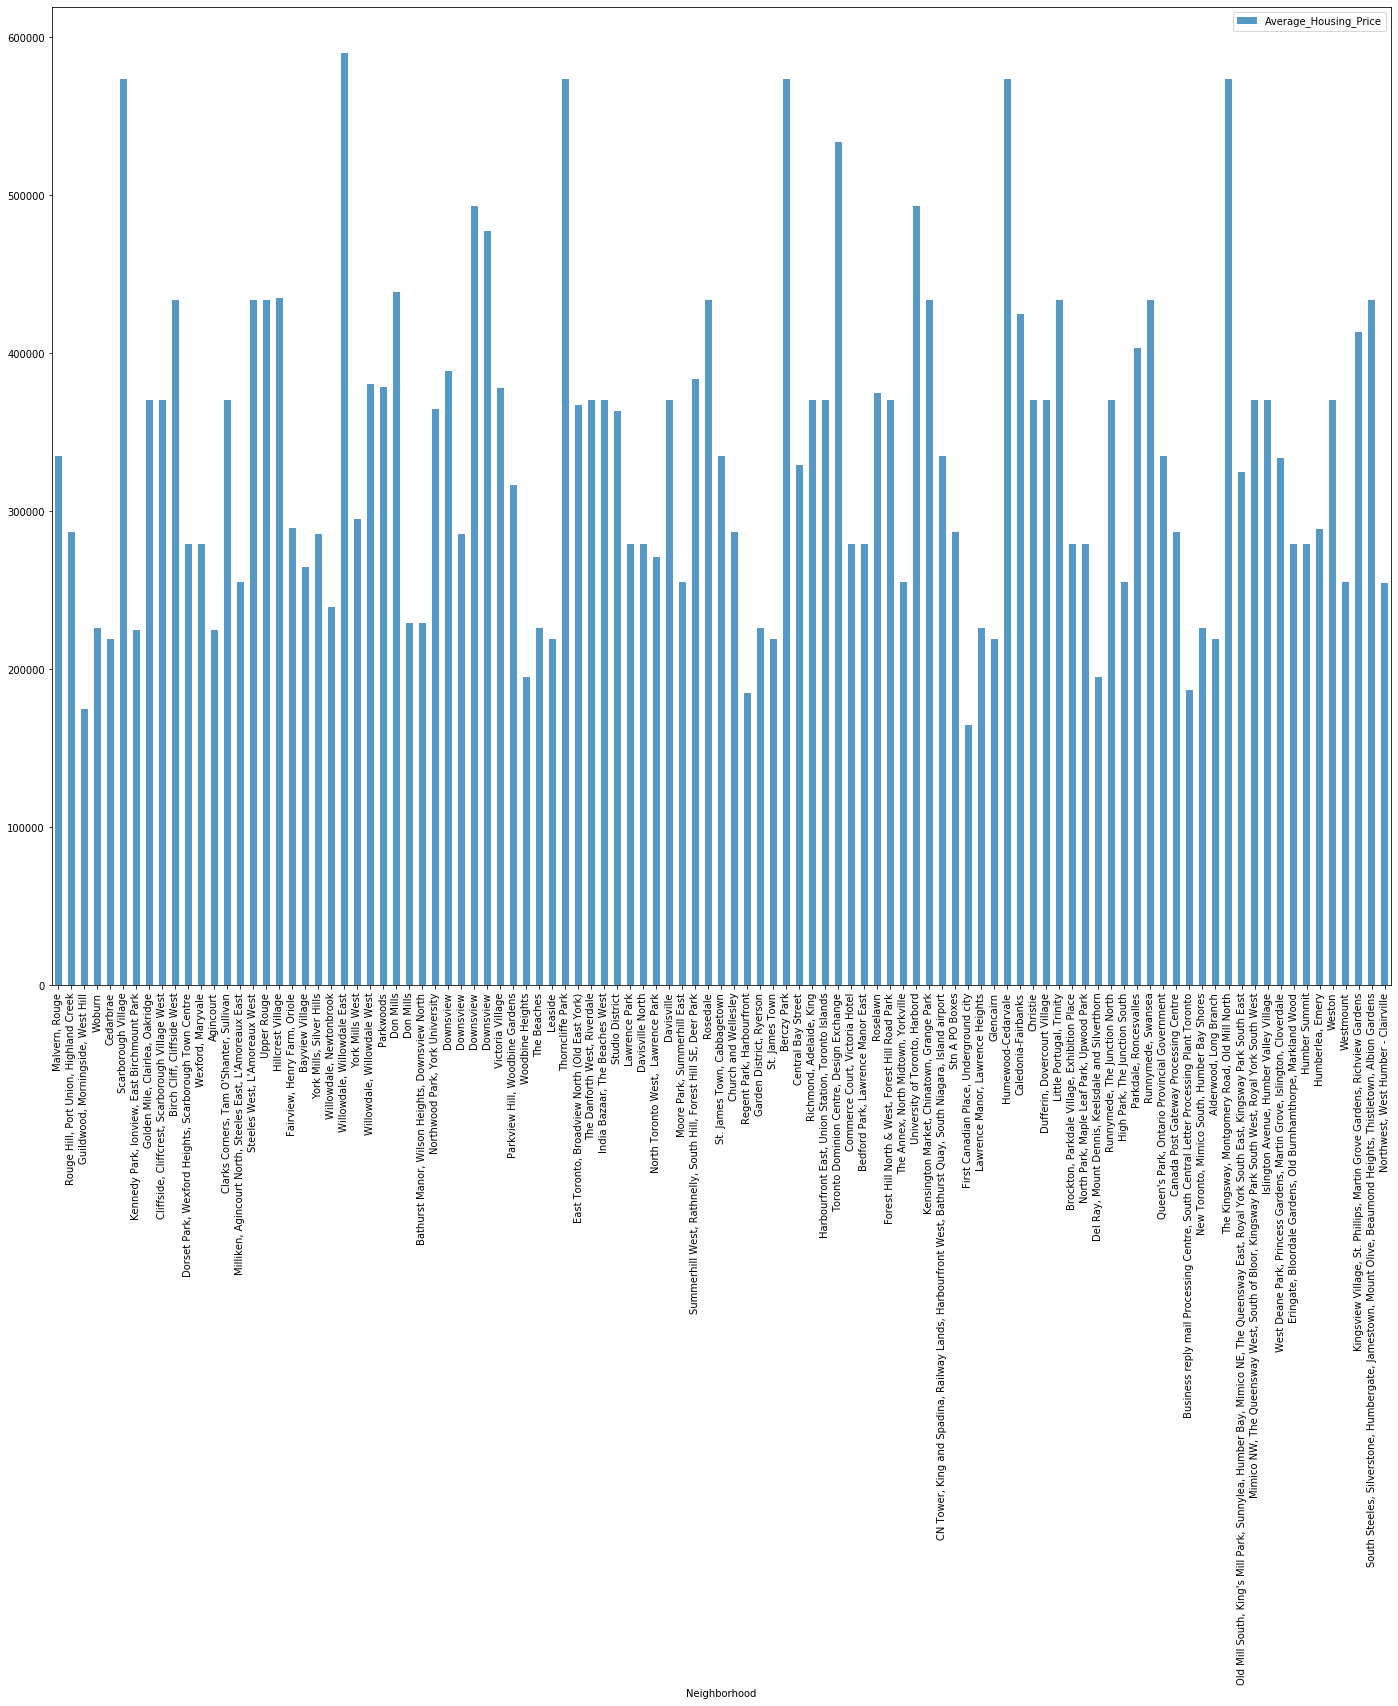

In [51]:
NorthYork_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [64]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [65]:
new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [66]:
NorthYork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

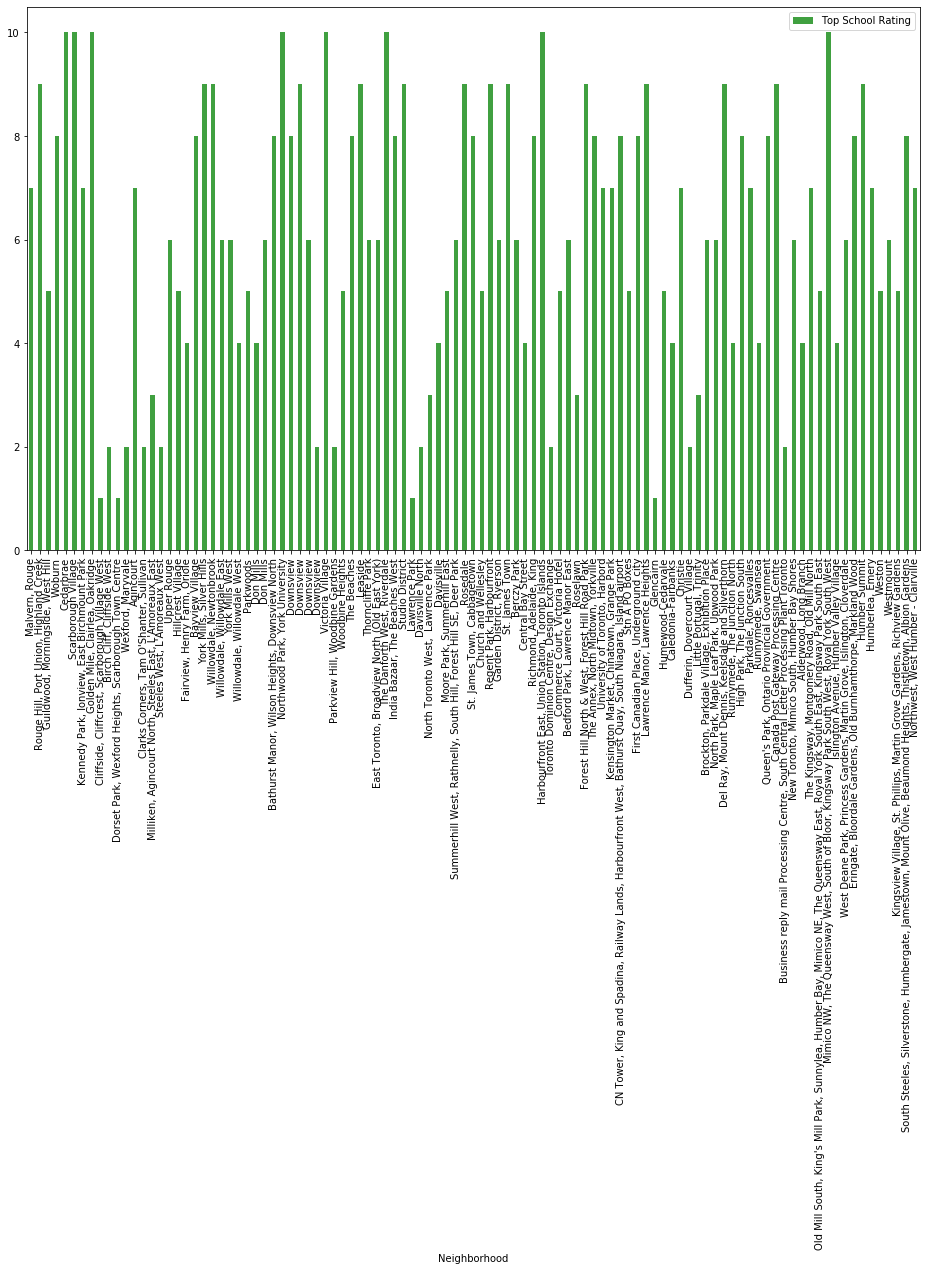

In [67]:
NorthYork_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.